In [1]:
# import all necessary things
%matplotlib nbagg

import qcodes as qc
import qcodes.instrument.parameter as parameter
import qcodes.instrument_drivers.AlazarTech.ATS9360 as ATSdriver
import qcodes.instrument_drivers.AlazarTech.ATS_acquisition_controllers as ats_contr

qc.halt_bg()
qc.set_mp_method('spawn')  # force Windows behavior on mac

# this makes a widget in the corner of the window to show and control
# subprocesses and any output they would print to the terminal
qc.show_subprocess_widget()

C:\Anaconda3\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


<IPython.core.display.Javascript object>

No loop running


a:\qcodesfolder\qcodes\process\helpers.py:27: UserWarning: Multiprocessing is in beta, use at own risk
  warnings.warn("Multiprocessing is in beta, use at own risk", UserWarning)


In [2]:
# Command to list all alazar boards connected to the system
ATSdriver.AlazarTech_ATS.find_boards()

[{'bits_per_sample': 12,
  'board_id': 1,
  'board_kind': 'ATS9360',
  'max_samples': 4294967294,
  'system_id': 1}]

In [3]:
# Create the ATS9870 instrument on the new server "alazar_server"
ats_inst = ATSdriver.AlazarTech_ATS9360(name='Alazar1', server_name="alazar_server")
# Print all information about this Alazar card
ats_inst.get_idn()

a:\qcodesfolder\qcodes\instrument\metaclass.py:37: UserWarning: Multiprocessing is in beta, use at own risk
  UserWarning)


{'CPLD_version': '25.16',
 'SDK_version': '5.10.6',
 'asopc_type': '1779598176',
 'driver_version': '5.10.6',
 'firmware': None,
 'latest_cal_date': '11-09-15',
 'memory_size': '4294967294',
 'model': 'ATS9360',
 'pcie_link_speed': '0.5GB/s',
 'pcie_link_width': '8',
 'serial': '970273',
 'vendor': 'AlazarTech'}

In [4]:
import qcodes.instrument_drivers.AlazarTech.basic_controller as basic_contr

basic_acquisition_controller = basic_contr.Basic_Acquisition_Controller(name='basic_acquisition_controller', 
                                                                      alazar_name='Alazar1', 
                                                                      server_name="alazar_server")

a:\qcodesfolder\qcodes\instrument\metaclass.py:37: UserWarning: Multiprocessing is in beta, use at own risk
  UserWarning)


In [5]:
# Configure all settings in the Alazar card
ats_inst.config(clock_source='EXTERNAL_CLOCK_10MHz_REF',
                sample_rate='10MHZ_REF_500MSPS',
                clock_edge='CLOCK_EDGE_RISING',
                decimation=1,
                coupling=['DC','DC'],
                channel_range=[.4,.4],
                #impedance=[50,50],
                #trigger_operation='TRIG_ENGINE_OP_J',
                #trigger_engine1='TRIG_ENGINE_J',
                #trigger_source1='EXTERNAL',
                #trigger_slope1='TRIG_SLOPE_POSITIVE',
                trigger_level1=140,
                #trigger_engine2='TRIG_ENGINE_K',
                #trigger_source2='DISABLE',
                #trigger_slope2='TRIG_SLOPE_POSITIVE',
                #trigger_level2=128,
                external_trigger_coupling='DC',
                external_trigger_range='ETR_2V5',
                #trigger_delay=0,
                #timeout_ticks=0
)

In [6]:
# This command is specific to this acquisition controller. The kwargs provided here are being forwarded to ats_inst.acquire
# This way, it becomes easy to change acquisition specific settings from the ipython notebook
basic_acquisition_controller.update_acquisitionkwargs(#mode='NPT',
                 samples_per_record=1024,
                 records_per_buffer=1,
                 buffers_per_acquisition=1,
                 #channel_selection='AB',
                 #transfer_offset=0,
                 #external_startcapture='ENABLED',
                 #enable_record_headers='DISABLED',
                 #alloc_buffers='DISABLED',
                 #fifo_only_streaming='DISABLED',
                 #interleave_samples='DISABLED',
                 #get_processed_data='DISABLED',
                 allocated_buffers=1,
                 #buffer_timeout=1000
)

In [7]:
data = basic_acquisition_controller.acquisition()

3.035316733376046

In [8]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(data[0])
plt.show()

{'__class__': 'qcodes.instrument_drivers.AlazarTech.ATS9870.AlazarTech_ATS9870',
 'functions': {},
 'name': 'Alazar1',
 'parameters': {'IDN': {'__class__': 'qcodes.instrument.parameter.StandardParameter',
   'instrument': 'qcodes.instrument_drivers.AlazarTech.ATS9870.AlazarTech_ATS9870',
   'instrument_name': 'Alazar1',
   'label': 'IDN',
   'name': 'IDN',
   'ts': '2016-09-21 18:04:30',
   'units': '',
   'value': {'CPLD_version': '13.8',
    'SDK_version': '5.10.15',
    'asopc_type': '2435577968',
    'driver_version': '5.10.15',
    'firmware': None,
    'latest_cal_date': '30-01-13',
    'memory_size': '4294966272',
    'model': 'ATS9870',
    'pcie_link_speed': '0.25GB/s',
    'pcie_link_width': '8',
    'serial': '910266',
    'vendor': 'AlazarTech'}},
  'alloc_buffers': {'__class__': 'qcodes.instrument_drivers.AlazarTech.ATS.AlazarParameter',
   'label': 'Alloc Buffers',
   'name': 'alloc_buffers',
   'ts': '2016-09-21 18:04:30',
   'units': '',
   'value': 'DISABLED'},
  'allo

DataSet:
   mode     = DataMode.LOCAL
   location = '2016-10-26/14-50-44_AlazarTest'
   <Type>   | <array_id>                         | <array.name> | <array.shape>
   Setpoint | dummy_set                          | dummy        | (50,)
   Measured | acquisition_controller_acquisition | acquisition  | (50,)
started at 2016-10-26 14:51:05


<IPython.core.display.Javascript object>


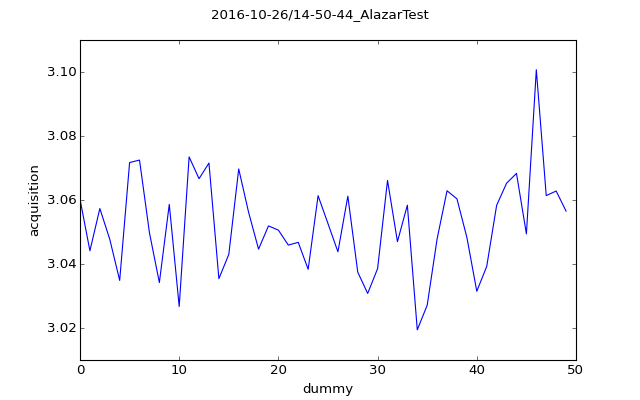

In [9]:
# Finally show that this instrument also works within a loop
dummy = parameter.ManualParameter(name="dummy")
data = qc.Loop(dummy[0:5:1]).each(basic_acquisition_controller.acquisition).run(name='AlazarTest')
qc.MatPlot(data.basic_acquisition_controller_acquisition_A)

In [ ]:
data